## **Init**

In [ ]:
import warnings
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

%matplotlib inline

In [ ]:
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla P100-PCIE-16GB


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
root = "/content/drive/My Drive/Practice/FOODC"

!ls "/content/drive/My Drive/Practice/FOODC"

checkpoints  csv  data	models	notebooks  test.csv  train.csv


## **Data Loading** 

In [ ]:
train_df = pd.read_csv(root+'/train.csv')
test_df = pd.read_csv(root+'/test.csv')

print("TRAIN CLASSES: ", train_df.columns.to_list())
print("TEST CLASSES: ", test_df.columns.to_list())

TRAIN CLASSES:  ['ImageId', 'ClassName']
TEST CLASSES:  ['ImageId']


In [ ]:
data_list = ImageList.from_df(path=root, df=train_df, cols=['ImageId'], folder='data/train_images').split_by_rand_pct(0.1).label_from_df(cols=['ClassName'])
test_list = ImageList.from_df(path=root, df=test_df, cols=['ImageId'], folder='data/test_images')
data_list.add_test(test_list)

def get_data(image_size, batch_size):
    tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
    data = (data_list.transform(
            tfms=tfms,
            size=image_size,
            resize_method=ResizeMethod.SQUISH)
                .databunch(bs=batch_size)
                .normalize(imagenet_stats))
    data.num_workers = 4
    assert sorted(set(train_df.ClassName.unique())) == sorted(data.classes), "Class Mismatch"
    print("[INFO] Number of Classes: ", data.c)
    return data

In [ ]:
temp = get_data(64, 32)
temp

[INFO] Number of Classes:  61


ImageDataBunch;

Train: LabelList (8391 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
water,pizza-margherita-baked,broccoli,salad-leaf-salad-green,egg
Path: /content/drive/My Drive/Practice/FOODC;

Valid: LabelList (932 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
boisson-au-glucose-50g,water,mixed-vegetables,dark-chocolate,coffee-with-caffeine
Path: /content/drive/My Drive/Practice/FOODC;

Test: LabelList (484 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/Practice/FOODC

In [ ]:
temp.show_batch(rows=2, figsize=(3,3)) #SHOWS IMAGES

In [ ]:
len(temp.classes)

61

## **Model**

In [ ]:
BATCH_SIZE = 32

In [ ]:
learn = create_cnn(get_data(32, BATCH_SIZE), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
learn.model_dir = root+'/checkpoints/fastai/'
learn.save('resnet_32')

learn = create_cnn(get_data(64, BATCH_SIZE), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
learn.model_dir = root+'/checkpoints/fastai/'
learn.load("resnet_32")
learn.save('resnet_64')

learn = create_cnn(get_data(128, BATCH_SIZE), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
learn.model_dir = root+'/checkpoints/fastai/'
learn.load("resnet_64")
learn.save('resnet_128')

learn = create_cnn(get_data(256, BATCH_SIZE), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
learn.model_dir = root+'/checkpoints/fastai/'
learn.load("resnet_128")
learn.save('resnet_256')

learn = create_cnn(get_data(512, (BATCH_SIZE//4)), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
learn.model_dir = root+'/checkpoints/fastai/'
learn.load('resnet_256')
learn.save('resnet_512')

[INFO] Number of Classes:  61


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth



[INFO] Number of Classes:  61
[INFO] Number of Classes:  61
[INFO] Number of Classes:  61
[INFO] Number of Classes:  61


In [ ]:
# LR1 and 2 unreliable

# TRAINER
def train_model(image_size, iter1, iter2, mixup=False):
    size_match = {"512": "256","256": "128", "128": "64", "64": "32"}
    if image_size == 512:
        train_batch_size = BATCH_SIZE//4
    else:
        train_batch_size = BATCH_SIZE

    learn = create_cnn(get_data(image_size ,train_batch_size), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
    learn.model_dir = root+'/checkpoints/fastai/'

    if str(image_size) != str(32):
        learn.load("resnet_" + str(size_match[str(image_size)]))
    if (mixup):
        learn.mixup()
    
    name = 'resnet_'+str(image_size)

    # Find LR1
    print("[INFO] Finding LR1... ")
    learn.lr_find()
    _ = input("[PROMPT] Press after ensureing tmp.pth exists")
    learn.recorder.plot(suggestion=True)
    LR1 = learn.recorder.min_grad_lr

    # Train 1
    print("[INFO] Training 1: ", name)
    learn.fit_one_cycle(cyc_len=iter1, max_lr=LR1, callbacks=[ShowGraph(learn),
                                                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])
    
    # Find LR2 after unfreezing
    learn.unfreeze()
    print("[INFO] Finding LR2... ")
    learn.lr_find()
    _ = input("[PROMPT] Press after ensureing tmp.pth exists")
    learn.recorder.plot(suggestion=True)
    LR2a = learn.recorder.min_grad_lr
    # LR2b = LR1 / 10

    # Train 2   ----------------  USE SLICE
    print("[INFO] Training 2: ", name)
    learn.fit_one_cycle(cyc_len=iter2, max_lr=LR2a, callbacks=[ShowGraph(learn),
                                                             SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

## **Training by progressive batches**

#### Batch 1 - 32

[INFO] Number of Classes:  61
[INFO] Finding LR1... 


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.29E-03
[PROMPT] Press after ensureing tmp.pth exists
[INFO] Training 1:  resnet_32


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,4.347932,7.375422,0.199571,0.094164,35:04
1,3.370095,3.961843,0.281116,0.115707,02:33
2,2.958369,2.602819,0.331545,0.164595,02:32
3,2.705789,2.456061,0.353004,0.187498,02:34
4,2.486142,2.419592,0.351931,0.189526,02:34


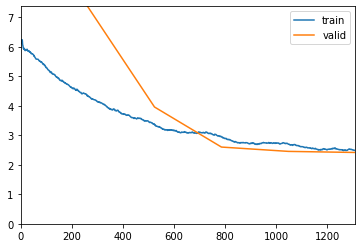

Better model found at epoch 0 with f_beta value: 0.09416399151086807.
Better model found at epoch 1 with f_beta value: 0.11570674926042557.
Better model found at epoch 2 with f_beta value: 0.1645945906639099.
Better model found at epoch 3 with f_beta value: 0.18749846518039703.
Better model found at epoch 4 with f_beta value: 0.18952573835849762.
[INFO] Finding LR2... 


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 6.31E-08
[PROMPT] Press after ensureing tmp.pth exists
[INFO] Training 2:  resnet_32


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,2.490552,2.404164,0.351931,0.183255,02:40
1,2.447206,2.423994,0.351931,0.185755,02:44
2,2.402445,2.404478,0.368026,0.211750,02:44


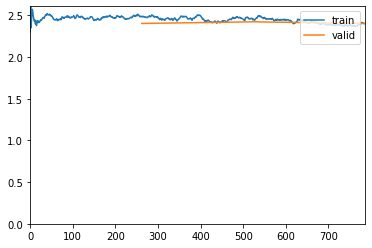

Better model found at epoch 0 with f_beta value: 0.1832549124956131.
Better model found at epoch 1 with f_beta value: 0.18575513362884521.
Better model found at epoch 2 with f_beta value: 0.211749866604805.


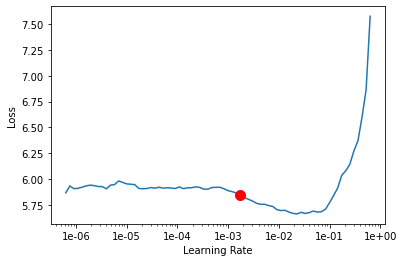

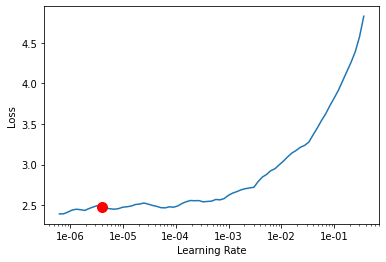

In [ ]:
# TRAINING
train_model(32, 5, 3)

#### Batch 2 - 64

In [ ]:
train_model(64, 5, 4)

#### Batch 3 - 128

In [ ]:
train_model(128, 7, 4, mixup=True)

#### Batch 4 - 256

In [ ]:
train_model(256, 7, 5, mixup=True)

#### Batch 5 - 512

In [ ]:
train_model(512, 6, 5, mixup=True)

## **Analysis**

In [ ]:
analyzer = create_cnn(get_data(512 ,BATCH_SIZE), models.resnet152, metrics=[accuracy, FBeta(beta=1, average='macro')], pretrained=True)
analyzer.model_dir = root+'/checkpoints/fastai/'
analyzer.load("trained_1")

In [ ]:
interp = ClassificationInterpretation.from_learner(analyzer)

In [ ]:
print("[INFO] MOST CONFUSED:")
interp.most_confused(min_val=4)

[INFO] MOST CONFUSED:


[('coffee-with-caffeine', 'espresso-with-caffeine', 10),
 ('bread-sourdough', 'bread-wholemeal', 5),
 ('butter', 'bread-wholemeal', 5),
 ('mixed-salad-chopped-without-sauce', 'salad-leaf-salad-green', 5),
 ('bread-white', 'butter', 4),
 ('bread-whole-wheat', 'bread-wholemeal', 4),
 ('butter', 'bread-white', 4),
 ('espresso-with-caffeine', 'coffee-with-caffeine', 4),
 ('tea-green', 'tea', 4)]

## **Get predictions for test data**

In [ ]:
# USING INBUILT PRED
pred_classes = []
pred_class_probs = []
probability, _ = analyzer.get_preds(ds_type=DatasetType.Test)
predictions = probability.argmax(axis=1)
for pred, prob in zip(predictions, probability):
    pred_classes.append(analyzer.data.classes[pred])
    pred_class_probs.append(prob.max().item())
display(pd.DataFrame({'ClassName': pred_classes, 'probability': pred_class_probs}).head())

,ClassName,probability
0,water,0.999997
1,water-mineral,0.956407
2,water,0.773574
3,hard-cheese,0.918963
4,bread-wholemeal,0.803181


In [ ]:
# CUSTOM PRED
def make_submission(learn, name):
    images = []
    prediction = []
    probability = []
    test_path = root+"/data/test_images/"
    test_df1 = pd.read_csv(root+"/test.csv")
    files = test_df1.ImageId
    for i in files:
            images.append(i)
            img = open_image(os.path.join(test_path, i))
            pred_class, pred_idx, outputs = learn.predict(img)
            prediction.append(pred_class.obj)
            probability.append(outputs.abs().max().item())
    answer = pd.DataFrame({'ImageId': images, 'ClassName': prediction, 'probability': probability})
    display(answer.head())
    answer[["ImageId","ClassName"]].to_csv(name, index=False)

In [ ]:
make_submission(analyzer, "submission_512.csv")

,ImageId,ClassName,probability
0,90e63a2fde.jpg,water,0.999997
1,a554d1ca8d.jpg,water-mineral,0.956407
2,48317e8ee8.jpg,water,0.773575
3,79528df667.jpg,hard-cheese,0.918963
4,6d2f2f63f5.jpg,bread-wholemeal,0.803180


In [ ]:
from google.colab import files
files.download('submission_512.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>